In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline  
import locale
locale.setlocale(locale.LC_TIME, "pt_PT") # processar datas em PT
from datetime import timedelta
import os
import sys
sys.path.append('../../src')
import aosol.series.consumo as series
import aosol.series.producao as seriesprod
import aosol.series.pvgis as pvgis
import aosol.analise.analise_energia as ae
import aosol.analise.analise_financeira as af
import aosol.analise.analise_precos_energia as ape
from aosol.armazenamento import bateria
from IPython.display import HTML, display, display_html

# Analise de UPAC

Analise de um projecto de UPAC com dados de consumo obtidos do portal e-redes, dados de produção obtidos da plataforma PVGIS e subsequente análise dos indicadores principais do projecto: indice auto consumo (IAC), indice de auto suficiência (IAS) e indice entrega à rede (IER). É feita também uma análise financeiro do projecto.

In [2]:
# Parametros do projecto
nome_projecto = 'Covilha_3.6kW'
# =====================
# Consumo
# =====================
ano_consumo = 2023
perfil = 'BTN C' # ver na document
consumo_anual = 8400 # kWh, exemplo consumo médio 700 kWh/mes
fich_perfil_eredes = r"./consumo/perfis_eredes/E-REDES_Perfil_Consumo_2023.csv"

# =====================
# Producao
# =====================
capacidade_instalada = 3.68 # em kW
ano_producao = 2023 # converter as datas de producao para este ano
# Opcoes API PVGIS
inicio_ano_pvgis = 2005
fim_ano_pvgis = 2023 # PVGIS-SARAH3 na V5.3 (2005-2023)
lat = 40.280  # Covilha
lon = -7.504
inclinacao = 30
azimute = 0.0 # azimute = 180 + x; 0 = Sul
perdas = 14 # %
eficiencia_inversor = 0.96

# =====================
# Analise energetica
# =====================
analise_com_bateria = False
capacidade_bat = 1.2 # kWh
soc_min = 20 # limite maximo descarregamento em % 
soc_max = 80 # limite maximo carregamento em %

# =====================
# Analise poupanca anual
# =====================
ano_tarifario = 2023
simples_kwh = 0.0 # simples
bihorario_fora_vazio_kwh = 0.1751
bihorario_vazio_kwh = 0.1001
trihorario_ponta_kwh = 0.0
trihorario_cheias_kwh = 0.0
trihorario_vazio_kwh = 0.0
# venda a rede com preco fixo
preco_venda_rede = 0.04 # 4cent/kWh
precos_energia = ape.TarifarioEnergia(simples_kwh, \
    bihorario_fora_vazio_kwh, bihorario_vazio_kwh, \
    trihorario_ponta_kwh, trihorario_cheias_kwh, trihorario_vazio_kwh, \
    preco_venda_rede)

# =====================
# Analise tempo de vida
# =====================
tempo_vida = 20 # anos
ano_0 = 2023 # ano 0 do projecto
taxa_actualizacao = 5 # em %
taxa_degradacao_sistema = 0.7 # %/ano
taxa_inflacao = 2.0 # %/ano

# Custos do projecto
#total = 1500 # €
# investimento_estimado = pv + instalacao + outros_custos
custo_pv = 2218 # 60% material
custo_instalacao = 450 # 30% instalacao
outros_custos = 150 # 10% outros custos
# custo manutencao anual como percentagem do investimento
perc_custo_manutencao = 0.5 # em %
# apoio estatal (fundo ambiental)
considerar_apoio = False
perc_apoio = 85 # em % do investimento estimado
apoio_max = 1000 # em €, valor maximo pago pelo fundo

## 1. Consumo

Utilização de perfil médio da e-redes

In [3]:
perfil_eredes = series.leitura_perfis_eredes(fich_perfil_eredes, perfil)
consumo = series.ajustar_perfil_eredes_a_consumo_anual(perfil_eredes, consumo_anual, 'BTN C', 'consumo')

Consumo anual = 8400.0 kWh


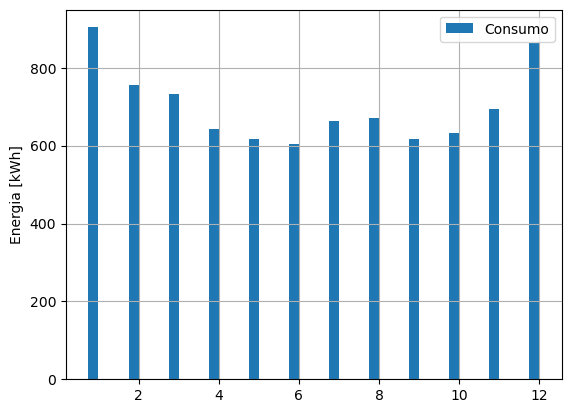

In [4]:
consumo_mensal = consumo['consumo'].resample('M').sum()

width = 0.25
plt.bar(consumo_mensal.index.month-width/2, consumo_mensal, width=width, label='Consumo')
plt.legend()
plt.ylabel('Energia [kWh]')
plt.grid()

print("Consumo anual = {:.1f} kWh".format(consumo['consumo'].sum()))

## 2. Produção

Produção estimada através do PV GIS

In [5]:
producao = pvgis.get_pvgis_hourly(lat, lon, inicio_ano_pvgis, fim_ano_pvgis, surface_tilt=inclinacao, surface_azimuth=azimute, peakpower=capacidade_instalada, loss=perdas)
producao = seriesprod.converter_pvgis_multiyear_ts(producao, ano_producao)

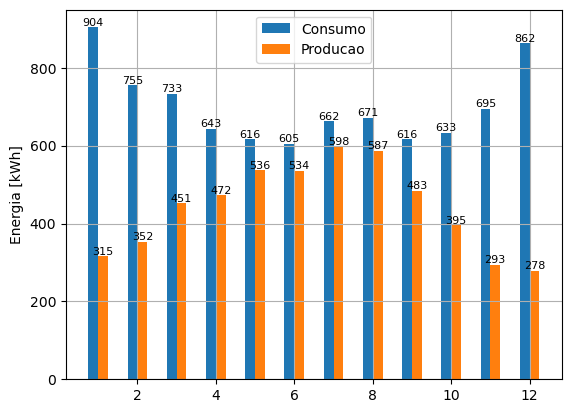

In [6]:
producao_mensal = producao.resample('M').sum()

fig, ax = plt.subplots()

width = 0.50
c = ax.bar(consumo_mensal.index.month-width/4, consumo_mensal, width=width/2, label='Consumo')
ax.bar_label(c, fmt='%d', fontsize=8)
p = ax.bar(producao_mensal.index.month+width/4, producao_mensal['autoproducao'], width=width/2, label='Producao')
ax.bar_label(p, fmt='%d', fontsize=8)
plt.legend()
plt.ylabel('Energia [kWh]')
plt.grid()

## 3. Análise energética do projecto

Analisar projecto de UPAC sem armazenamento através dos seguintes indicadores

* Indice de auto consumo : fraccao da producao que é consumida

* Indice de auto suficiencia : fracao do consumo que é suprida pela producao

* Indice de entrega a rede : fraccao da producao que nao e consumida e é entregue a rede

In [7]:
# juntar consumo com autoproducao na mesma frame
energia = consumo['consumo'].to_frame('consumo')
energia = energia.join(producao, how="outer")

# calcula upac sem armazenamento
energia = ae.analisa_upac_sem_armazenamento(energia, eficiencia_inversor)

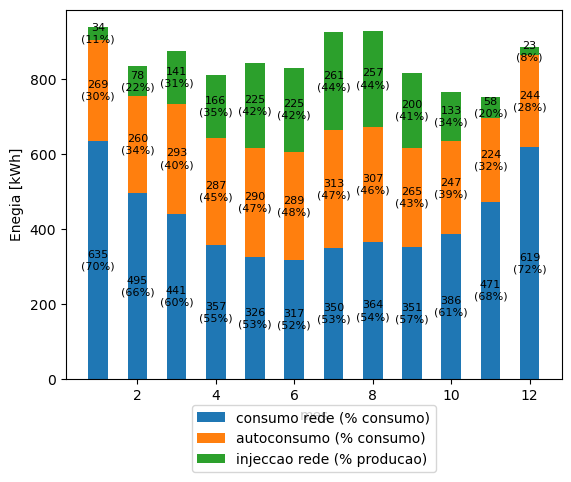

In [8]:
energia_mensal = energia.resample('M').sum()

fig, ax = plt.subplots()

# plot mean P50
ae.plot_energia_mensal_bars(ax, energia_mensal, consumo_mensal, producao_mensal["autoproducao"], ["consumo_rede", "autoconsumo", "injeccao_rede"])

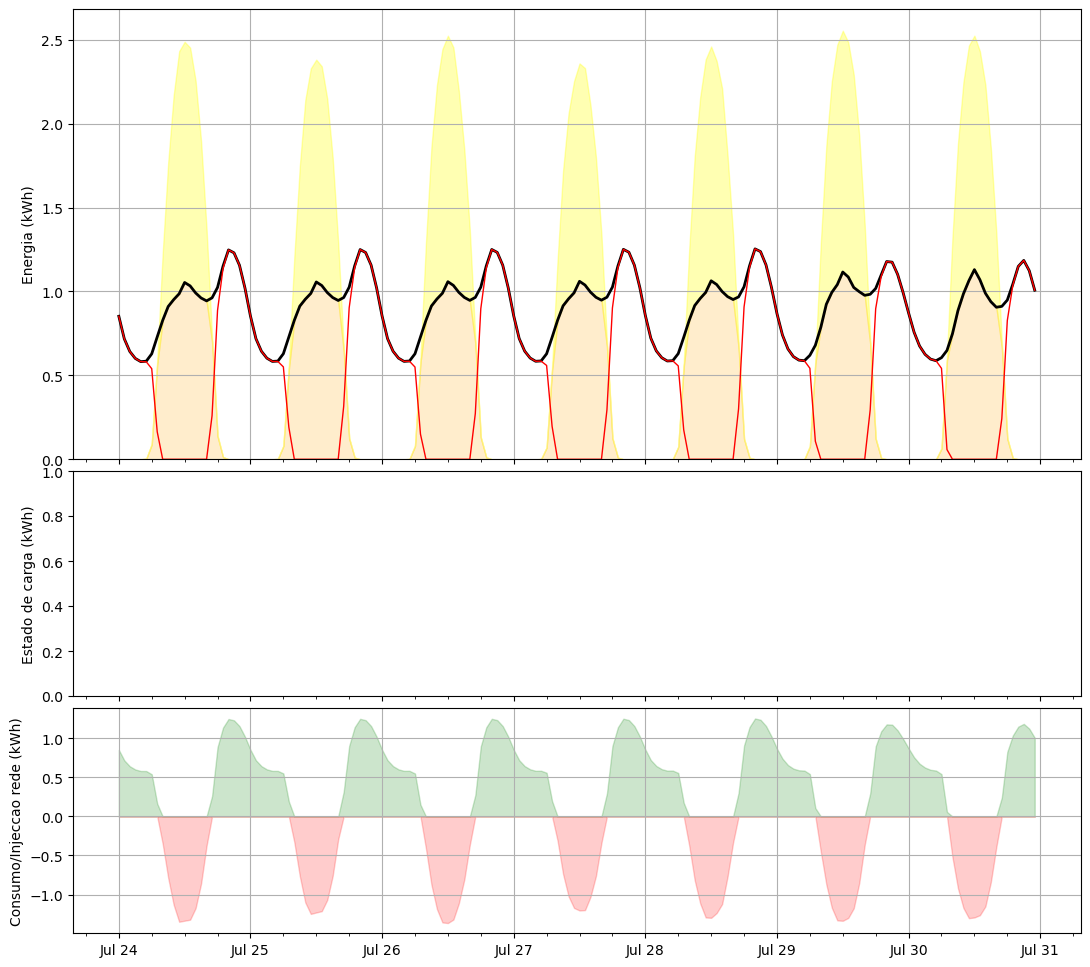

In [10]:
ae.plot_despacho_energia(energia, 30)

In [11]:
indicadores = ae.calcula_indicadores_autoconsumo(energia, capacidade_instalada, eficiencia_inversor)
indicadores.print_html("P50")

label,P50
Potencia instalada [kW],3.7
IAS: Contributo PV [%],39.2
IAC: Indice Auto consumo [%],62.1
IER: Producao PV desperdicada [%],37.9
Energia consumida [kWh],8400.0
Energia Autoproduzida [kWh],5300.0
Energia Autoconsumida [kWh],3289.0
Energia consumida rede [kWh],5111.0
Energia injectada rede [kWh],1799.0
Perdas inversor [kWh],212.0


## 4. Análise de poupanca anual

Custos mensais por tipo tarifario.

### 4.1 UPAC sem venda à rede

#### Tarifário Simples vs Bihorário vs Trihorário

In [12]:
#mensal_simples = af.analise_poupanca_anual_fatura(energia, ape.Tarifario.Simples, precos_energia, False, ['consumo', 'consumo_rede'])
#simples_styler = mensal_simples.style.format("{:.2f} €").set_caption('Tarifario Simples P50').set_table_attributes("style='display:inline'")

mensal_bihorario = af.analise_poupanca_anual_fatura(energia, ape.Tarifario.Bihorario, precos_energia, False, ['consumo', 'consumo_rede'])
bihorario_styler = mensal_bihorario.style.format("{:.2f} €").set_caption('Tarifario Bi-horário P50').set_table_attributes("style='display:inline'")

#mensal_trihorario = af.analise_poupanca_anual_fatura(energia, ape.Tarifario.Trihorario, precos_energia, False, ['consumo', 'consumo_rede'], ano_tarifario)
#trihorario_styler = mensal_trihorario.style.format("{:.2f} €").set_caption('Tarifario Tri-horário P50').set_table_attributes("style='display:inline'")

# display todos
#display_html(simples_styler._repr_html_() + bihorario_styler._repr_html_() + trihorario_styler._repr_html_(), raw=True)
# so simples
#display_html(simples_styler._repr_html_(), raw=True)
# so bihorario
display_html(bihorario_styler._repr_html_(), raw=True)
# so trihorario
#display_html(trihorario_styler._repr_html_(), raw=True)

,fatura sem upac,fatura com upac,poupanca
mes,,,
Janeiro,169.87 €,111.68 €,58.19 €
Fevereiro,142.00 €,85.81 €,56.19 €
Março,138.00 €,75.29 €,62.71 €
Abril,121.39 €,60.75 €,60.64 €
Maio,116.08 €,55.50 €,60.58 €
Junho,113.74 €,53.44 €,60.30 €
Julho,124.07 €,58.44 €,65.63 €
Agosto,125.83 €,61.10 €,64.73 €
Setembro,115.96 €,59.92 €,56.04 €


### 4.2 UPAC com venda à rede

#### Tarifários

In [13]:
#mensal_simples = af.analise_poupanca_anual_fatura(energia, ape.Tarifario.Simples, precos_energia, True, ['consumo', 'consumo_rede', 'injeccao_rede'])
#simples_styler = mensal_simples.style.format("{:.2f} €").set_caption('Tarifario Simples P50').set_table_attributes("style='display:inline'")

mensal_bihorario = af.analise_poupanca_anual_fatura(energia, ape.Tarifario.Bihorario, precos_energia, True, ['consumo', 'consumo_rede', 'injeccao_rede'])
bihorario_styler = mensal_bihorario.style.format("{:.2f} €").set_caption('Tarifario Bi-horário P50').set_table_attributes("style='display:inline'")

#mensal_trihorario = af.analise_poupanca_anual_fatura(energia, ape.Tarifario.Trihorario, precos_energia, True, ['consumo', 'consumo_rede', 'injeccao_rede'], ano_tarifario)
#trihorario_styler = mensal_trihorario.style.format("{:.2f} €").set_caption('Tarifario Tri-horário P50').set_table_attributes("style='display:inline'")

# display todos
#display_html(simples_styler._repr_html_() + bihorario_styler._repr_html_() + trihorario_styler._repr_html_(), raw=True)
# so simples
#display_html(simples_styler._repr_html_(), raw=True)
# so bihorario
display_html(bihorario_styler._repr_html_(), raw=True)
# so trihorario
#display_html(trihorario_styler._repr_html_(), raw=True)

,fatura sem upac,fatura com upac,poupanca,venda a rede
mes,,,,
Janeiro,169.87 €,111.68 €,59.54 €,1.35 €
Fevereiro,142.00 €,85.81 €,59.33 €,3.14 €
Março,138.00 €,75.29 €,68.35 €,5.64 €
Abril,121.39 €,60.75 €,67.30 €,6.66 €
Maio,116.08 €,55.50 €,69.57 €,8.99 €
Junho,113.74 €,53.44 €,69.28 €,8.98 €
Julho,124.07 €,58.44 €,76.08 €,10.45 €
Agosto,125.83 €,61.10 €,74.99 €,10.26 €
Setembro,115.96 €,59.92 €,64.02 €,7.98 €


## 5. Analise Financeira do projecto no tempo de vida

Calcular indicadores financeiros para o tempo de vida do projecto.

* VAL

* TIR

* Tempo retorno projecto

In [14]:
investimento_estimado = custo_pv + custo_instalacao + outros_custos

# Custo de manutencao anual
custo_manutencao = investimento_estimado * (perc_custo_manutencao / 100)

# Apoio fundo ambiental
apoio = 0
if considerar_apoio:
   apoio = min(investimento_estimado*(perc_apoio/100), apoio_max)
   investimento_estimado = investimento_estimado - apoio

print(f"Investimeto total = {investimento_estimado:.2f} €")
print(f"Custos OM = {custo_manutencao:.2f} €/ano")

Investimeto total = 2818.00 €
Custos OM = 14.09 €/ano


### 5.1 UPAC sem venda à rede

In [15]:
cols = ['consumo', 'consumo_rede']

#indicadores_financas_simples, cf_simples = af.analise_financeira_projecto_faturas(energia, investimento_estimado, custo_manutencao, taxa_actualizacao, ano_0, tempo_vida, taxa_degradacao_sistema, taxa_inflacao, ape.Tarifario.Simples, precos_energia, False, cols, indicadores)
#simples_style = indicadores_financas_simples.as_frame().style.format("{:.2f}").set_caption('Tarifario Simples P50').set_table_attributes("style='display:inline'")

indicadores_financas_bihorario, _ = af.analise_financeira_projecto_faturas(energia, investimento_estimado, custo_manutencao, taxa_actualizacao, ano_0, tempo_vida, taxa_degradacao_sistema, taxa_inflacao, ape.Tarifario.Bihorario, precos_energia, False, cols, indicadores)
bihorario_style = indicadores_financas_bihorario.as_frame().style.format("{:.2f}").set_caption('Tarifario Bi-horário P50').set_table_attributes("style='display:inline'")

#indicadores_financas_trihorario, _ = af.analise_financeira_projecto_faturas(energia, investimento_estimado, custo_manutencao, taxa_actualizacao, ano_0, tempo_vida, taxa_degradacao_sistema, taxa_inflacao, ape.Tarifario.Trihorario, precos_energia, False, cols, indicadores)
#trihorario_style = indicadores_financas_trihorario.as_frame().style.format("{:.2f}").set_caption('Tarifario Tri-horário P50').set_table_attributes("style='display:inline'")

# display todos
#display_html(simples_style._repr_html_() + bihorario_style._repr_html_() + trihorario_style._repr_html_(), raw=True)
# so simples
#display_html(simples_style._repr_html_(), raw=True)
# so bihorario
display_html(bihorario_style._repr_html_(), raw=True)
# so trihorario
#display_html(trihorario_style._repr_html_(), raw=True)

,valores
indice,
Tempo vida util projecto [anos],20.00
Custo instalação [€],2818.00
Custo manutenção anual [€/ano],14.09
VAL [€],6567.74
TIR [%],25.16
Retorno do investimento [anos],4.60
Lcoe [€/kWh],0.05


### 5.2 UPAC com venda à rede

In [16]:
cols = ['consumo', 'consumo_rede', 'injeccao_rede']
cols_p90 = ['consumo', 'consumo_rede_p90', 'injeccao_rede_p90']

# custos tarifario simples
#indicadores_financas_simples, cf_simples = af.analise_financeira_projecto_faturas(energia, investimento_estimado, custo_manutencao, taxa_actualizacao, ano_0, tempo_vida, taxa_degradacao_sistema, taxa_inflacao, ape.Tarifario.Simples, precos_energia, True, cols, indicadores)
#simples_style = indicadores_financas_simples.as_frame().style.format("{:.2f}").set_caption('Tarifario Simples P50').set_table_attributes("style='display:inline'")

indicadores_financas_bihorario, cf_bihorario = af.analise_financeira_projecto_faturas(energia, investimento_estimado, custo_manutencao, taxa_actualizacao, ano_0, tempo_vida, taxa_degradacao_sistema, taxa_inflacao, ape.Tarifario.Bihorario, precos_energia, True, cols, indicadores)
bihorario_style = indicadores_financas_bihorario.as_frame().style.format("{:.2f}").set_caption('Tarifario Bi-horário P50').set_table_attributes("style='display:inline'")

#indicadores_financas_trihorario, _ = af.analise_financeira_projecto_faturas(energia, investimento_estimado, custo_manutencao, taxa_actualizacao, ano_0, tempo_vida, taxa_degradacao_sistema, taxa_inflacao, ape.Tarifario.Trihorario, precos_energia, True, cols, indicadores)
#trihorario_style = indicadores_financas_trihorario.as_frame().style.format("{:.2f}").set_caption('Tarifario Tri-horário P50').set_table_attributes("style='display:inline'")

# display todos
#display_html(simples_styler._repr_html_() + bihorario_styler._repr_html_() + trihorario_style._repr_html_(), raw=True)
# so simples
#display_html(simples_styler._repr_html_(), raw=True)
# so bihorario
display_html(bihorario_style._repr_html_(), raw=True)
# so trihorario
#display_html(trihorario_style._repr_html_(), raw=True)

,valores
indice,
Tempo vida util projecto [anos],20.00
Custo instalação [€],2818.00
Custo manutenção anual [€/ano],14.09
VAL [€],7563.43
TIR [%],27.83
Retorno do investimento [anos],4.10
Lcoe [€/kWh],0.05
